<a href="https://colab.research.google.com/github/Manjesh80/ml/blob/main/custom_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/manjesh80/ml.git
!cp ml/* .

Cloning into 'ml'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 1.07 MiB | 2.22 MiB/s, done.


In [2]:
import subprocess
import torch

def useGPU():
    is_gpu_available = torch.cuda.is_available()
    snail = u'\U0001F40C'
    rocket = u'\U0001F680'
    check = u'\u2705'
    party_emoji  = u'\U0001F973'

    if not is_gpu_available:
        print(f"No GPU detected! This notebook will be\033[1;35m\033[5m very slow {snail}. \033[0m")
        print(f"Consider uploading the notebook to one of the cloud platforms \033[1;31m\033[5m for much faster computation\033[0m {rocket}.\n")
        print(f"{check} \u001b[32mAlso, remember you might have to change the runtime type of your notebook!\032")
    else:
        print(f"GPU available")

def install_packages(packages):
    check = u'\u2705'
    print("\033[1mInstalling base requirements...\n\033[0m")
    for package in packages:
        process_scatter = subprocess.run(
            ["pip", "install", package],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
        )
        if process_scatter.returncode != 0:
            print(f"Installation of {package} failed with error:\n{process_scatter.stderr.decode('utf-8')}")
        else:
            print(f"{check} {package} installation completed successfully!\n")

def has_gpu():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

In [3]:
has_gpu()

Fri Jan 12 16:55:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
packages = [ "transformers[torch]", "datasets","torchinfo" ]

install_packages(packages)

Installing base requirements...

✅ transformers[torch] installation completed successfully!

✅ datasets installation completed successfully!

✅ torchinfo installation completed successfully!



In [6]:
import pandas as pd
import numpy as np
from datasets import *
import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('AirlineTweets.csv')
df = df[['airline_sentiment','text']]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

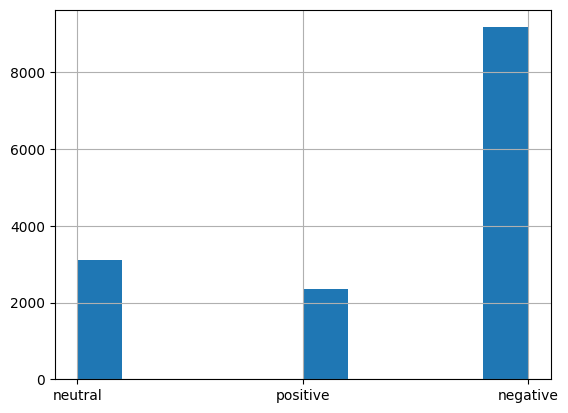

In [8]:
df['airline_sentiment'].hist()

In [9]:
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)
df1 = df[['text','target']]
df1.columns = ['sentence','label']
df1.to_csv('cleansed_data.csv', index = False)
raw_dataset = load_dataset('csv', data_files = 'cleansed_data.csv')
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
split

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [10]:
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased'
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [11]:
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

tokenized_dataset = split.map(tokenize_fn, batched = True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [12]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 10

In [14]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)


In [15]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.564600,0.418776,0.836976,0.836976
2,0.355900,0.453348,0.846311,0.846311
3,0.213300,0.621533,0.844945,0.844945


TrainOutput(global_step=1923, training_loss=0.3308614531470907, metrics={'train_runtime': 111.3402, 'train_samples_per_second': 276.127, 'train_steps_per_second': 17.271, 'total_flos': 769890416007888.0, 'train_loss': 0.3308614531470907, 'epoch': 3.0})

In [16]:
from transformers import pipeline


In [17]:
! ls training_dir


checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [19]:
saved_model = pipeline('text-classification',
                       model = 'training_dir/checkpoint-1282')

In [20]:
prediction = saved_model(split['test']['sentence'])

In [21]:
def get_label(d):
  return int(d['label'].split('_')[1])

predictions = [get_label(d) for d in prediction]

print("acc:",accuracy_score(split['test']['label'], predictions))


acc: 0.8463114754098361


In [22]:
print("f1:",f1_score(split['test']['label'], predictions, average = 'macro'))

f1: 0.7872445064204769


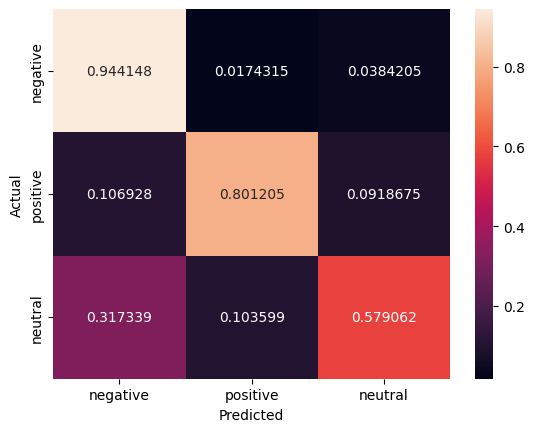

In [23]:
import seaborn as sns

def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'],predictions, normalize = 'true')
plot_cm(cm)